#Speech Command Recognition

The purpose of this project is to use audio feature extraction and neural networks to identify 35 simple spoken commands.  This model could be used where single word commands need to be identified for interaction with automated systems.

The original data, available and crowdsourced by Google's AIY project and the TensorFlow team, can be found [here](https://ai.googleblog.com/2017/08/launching-speech-commands-dataset.html). Examples of existing research and documentation can be found in this [Bibliography](https://docs.google.com/document/d/1KtxPHVX04ckFckqGBh2zfX-OHk5cBf-ZpomcGE-9u_g/edit?usp=sharing).

I chose to tackle this problem because of my ongoing interest in audio information retrieval and my desire to learn the Librosa library, as well as my future interest in incorporating deep learning into my electronic art.

#***Import libraries***

In [ ]:
import pandas as pd
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import matplotlib.style as ms
ms.use('seaborn-muted')
%matplotlib nbagg
%matplotlib inline
import IPython.display as ipd
from IPython.display import Audio
import os, sys
from scipy.io import wavfile
from sklearn.preprocessing import LabelEncoder, scale
import time
import tensorflow as tf
tf.config.list_physical_devices('GPU')
from numpy import asarray
from numpy import savetxt

In [ ]:
#!pip install tensorflow-gpu

import warnings
warnings.filterwarnings('ignore')
from tensorflow.keras.utils import to_categorical
from keras.utils import np_utils
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, Input, MaxPooling2D, Conv1D, MaxPooling1D, Lambda
from tensorflow.keras import losses
from tensorflow import keras
from sklearn.model_selection import train_test_split
from keras.models import Model, Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

path = "/content/gdrive/My Drive/Thinkful/ZZZ Final Project/words/"
path2 = "/content/gdrive/My Drive/Thinkful/ZZZ Final Project/extracted_arrays/"

labels = os.listdir(path)

labels = labels[1:]

labels

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


['bed',
 'bird',
 'cat',
 'dog',
 'down',
 'eight',
 'five',
 'follow',
 'forward',
 'four',
 'go',
 'happy',
 'house',
 'learn',
 'left',
 'marvin',
 'nine',
 'no',
 'off',
 'on',
 'one',
 'right',
 'seven',
 'sheila',
 'six',
 'stop',
 'three',
 'tree',
 'two',
 'visual',
 'up',
 'wow',
 'yes',
 'zero']

#***EDA + Feature Engineering***

##Examine Data

How are the labels distributed?

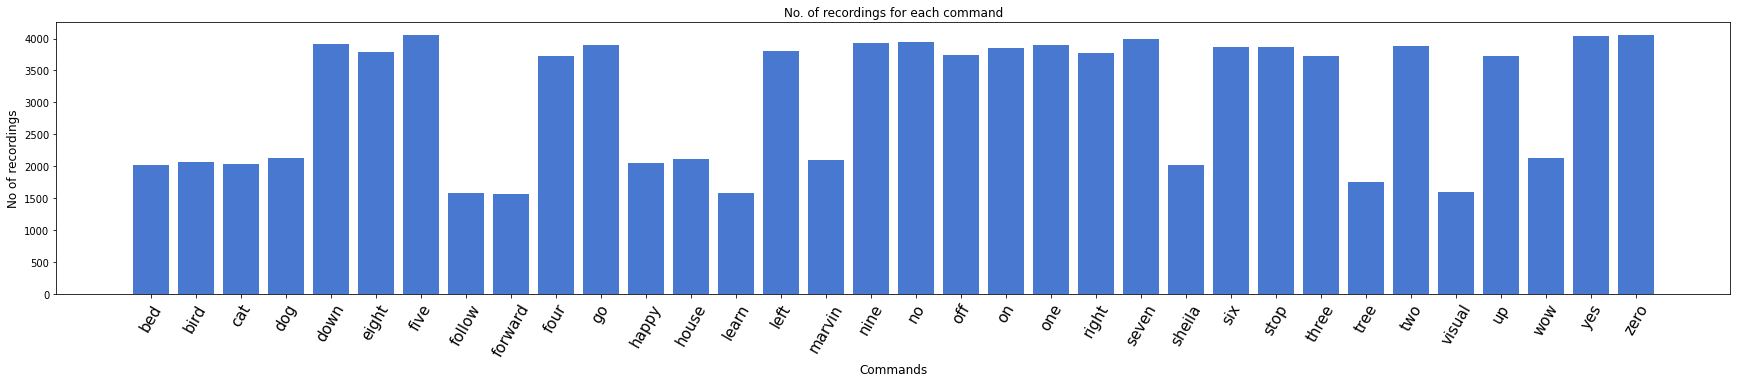

Run time: 163.87949514389038


In [ ]:
time_start = time.time()

number_of_recordings = []

for label in labels:
  waves = [f for f in os.listdir(path + '/'+ label) if f.endswith('.wav')]
  number_of_recordings.append(len(waves))

plt.figure(figsize=(30,5))
index = np.arange(len(labels))
plt.bar(index, number_of_recordings)
plt.xlabel('Commands', fontsize=12)
plt.ylabel('No of recordings', fontsize=12)
plt.xticks(index, labels, fontsize=15, rotation=60)
plt.title('No. of recordings for each command')
plt.show()

print('Run time: {} mins'.format((time.time()-time_start))/60)

How long are the recordings?

bed
bird
cat
dog
down
eight
five
follow
forward
four
go
happy
house
learn
left
marvin
nine
no
off
on
one
right
seven
sheila
six
stop
three
tree
two
visual
up
wow
yes
zero


TypeError: ignored

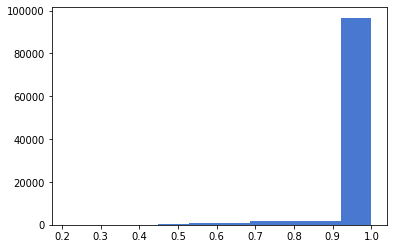

In [ ]:
time_start = time.time()

duration_of_recordings=[]
for label in labels:
    print(label)
    waves = [f for f in os.listdir(path + '/'+ label) if f.endswith('.wav')]
    for wav in waves:
        sample_rate, samples = wavfile.read(path + '/' + label + '/' + wav)
        duration_of_recordings.append(float(len(samples)/sample_rate))
    
plt.hist(np.array(duration_of_recordings))

print('Run time: {} mins'.format((time.time()-time_start)/60))

The above error is because I put a parenthesis in the wrong place, but it did no harm and the code took five hours to run, so I'm not re-running it.

In [ ]:
savetxt('number_of_recordings.csv', number_of_recordings, delimiter=',')
savetxt('duration_of_recordings.csv', duration_of_recordings, delimiter=',')

How many audio files are there?

In [ ]:
sum(number_of_recordings)

104228

In [ ]:
np.unique(duration_of_recordings, return_counts=True)

(array([0.2133125, 0.256    , 0.278625 , 0.298625 , 0.3250625, 0.3413125,
        0.3626875, 0.3715   , 0.3715625, 0.384    , 0.3946875, 0.4179375,
        0.418    , 0.426625 , 0.4266875, 0.448    , 0.4586875, 0.464375 ,
        0.4644375, 0.4693125, 0.469375 , 0.48     , 0.4906875, 0.501375 ,
        0.5108125, 0.510875 , 0.512    , 0.5226875, 0.5333125, 0.533375 ,
        0.554625 , 0.5546875, 0.55725  , 0.5573125, 0.565375 , 0.576    ,
        0.5866875, 0.5973125, 0.597375 , 0.6036875, 0.60375  , 0.608    ,
        0.6186875, 0.627    , 0.6293125, 0.629375 , 0.64     , 0.650125 ,
        0.6501875, 0.6506875, 0.6613125, 0.661375 , 0.672    , 0.682625 ,
        0.6826875, 0.6933125, 0.693375 , 0.6965625, 0.696625 , 0.704    ,
        0.7146875, 0.7253125, 0.725375 , 0.736    , 0.743    , 0.7430625,
        0.7466875, 0.74825  , 0.7485   , 0.75325  , 0.7535   , 0.7573125,
        0.757375 , 0.75825  , 0.7585   , 0.76325  , 0.7635   , 0.7663125,
        0.768    , 0.76825  , 0.7685  

**There are 35 labels, somewhat imbalanced, and 104,228 audio files.  About 90% of the samples are exactly 1.0 second long, so files shorter than this will not be included for a total of 93,894 audio files.**

##Resampling and Computing MFCCs

**I'll resample each audio clip to 8000 Hz, since most relevant speech information is present in audible frequencies below 4000 Hz (source 17).  I'll also calculate the log-scaled Mel frequency cepstrum coefficients (MFCCs) for each sample.  These effectively take an FFT of the audio scaled for human-ear perception of frequency and loudness and divide it by time bands sized to capture individual phonemes.  They are frequently used in speech analysis.**

**The samples are crowd-sourced and vary in background noise and volume, and in order for Librosa's built-in audio normalization features to achieve a better result, the samples would first need to be filtered.  Designing an audio filter system is beyond the scope of this project. In addition, a real system receives unfiltered and non-normalized audio, so it may be valuable to train a model on this realistic data.**

In [ ]:
labels2 = labels[14:]

labels2

['left',
 'marvin',
 'nine',
 'no',
 'off',
 'on',
 'one',
 'right',
 'seven',
 'sheila',
 'six',
 'stop',
 'three',
 'tree',
 'two',
 'visual',
 'up',
 'wow',
 'yes',
 'zero']

In [ ]:
time_start = time.time()

path = "/content/gdrive/My Drive/Thinkful/ZZZ Final Project/words/"

path2 = "/content/gdrive/My Drive/Thinkful/ZZZ Final Project/extracted_arrays/"

labels2 = labels[14:]

for label in labels2:

    audio_onesec = []
    label_list = []
    mfccs = []

    print(label)
    waves = [f for f in os.listdir(path + '/'+ label) if f.endswith('.wav')]

    for wav in waves:
        samples, sample_rate = librosa.load(path + '/' + label + '/' + wav, sr = 16000)
        samples = librosa.resample(samples, 16000, 8000)
        if(len(samples) == 8000) : 
            audio_onesec.append(samples)
            label_list.append(label)

            S = librosa.feature.melspectrogram(y=samples, sr=8000, n_mels=26, fmax=4000)
            mels = librosa.feature.mfcc(y=samples, sr=8000, S=librosa.power_to_db(S))
            mfccs.append(mels)

    np.save(os.path.join(path2, str(label) + '_audio_onesec'), audio_onesec)
    np.save(os.path.join(path2, str(label) + '_label_list'), label_list)
    np.save(os.path.join(path2, str(label) + '_mfccs'), mfccs)
    print(label, 'is done')

print('Run time: {}'.format(time.time()-time_start))

left
left is done
marvin
marvin is done
nine
nine is done
no
no is done
off
off is done
on
on is done
one
one is done
right
right is done
seven
seven is done
sheila
sheila is done
six
six is done
stop
stop is done
three
three is done
tree
tree is done
two
two is done
visual
visual is done
up
up is done
wow
wow is done
yes
yes is done
zero
zero is done
Run time: 25985.137543916702


The next cells are re-extracting the MFCCs so there are 26 of them.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

path = "/content/gdrive/My Drive/Thinkful/ZZZ Final Project/words/"

labels = os.listdir(path)

labels = labels[1:]

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
path2 = "/content/gdrive/My Drive/Thinkful/ZZZ Final Project/extracted_arrays/"

time_start = time.time()

for label in labels:
  mfccs = []

  print(label)
  samples = np.load(os.path.join(path2, str(label) + '_audio_onesec.npy'))
  
  for sample in samples:
    mels = librosa.feature.mfcc(y=sample, sr=8000, n_mfcc=26)
    mels = scale(mels, axis=1)
    mfccs.append(mels)
  
  np.save(os.path.join(path2, str(label) + '_mfccs2'), mfccs)
  print(label, 'is done')


print('Run time: {}'.format(time.time()-time_start))

bed
bed is done
bird
bird is done
cat
cat is done
dog
dog is done
down
down is done
eight
eight is done
five
five is done
follow
follow is done
forward
forward is done
four
four is done
go
go is done
happy
happy is done
house
house is done
learn
learn is done
left
left is done
marvin
marvin is done
nine
nine is done
no
no is done
off
off is done
on
on is done
one
one is done
right
right is done
seven
seven is done
sheila
sheila is done
six
six is done
stop
stop is done
three
three is done
tree
tree is done
two
two is done
visual
visual is done
up
up is done
wow
wow is done
yes
yes is done
zero
zero is done
Run time: 411.3979437351227


##Compile numpy array

In [ ]:
mfccs1_2 = np.load(os.path.join(path2, 'bed_mfccs2.npy'))

mfccs1_2.shape

(1686, 26, 16)

In [ ]:
audio_samples1 = np.load(os.path.join(path2, 'bed_audio_onesec.npy'))

audio_samples1.shape

(1686, 8000)

In [ ]:
labels1 = np.load(os.path.join(path2, 'bed_label_list.npy'))

labels1.shape

(1686,)

In [ ]:
all_audio = np.empty([0, 8000])

for label in labels:
  audiosamples = np.load(os.path.join(path2, str(label) + '_audio_onesec.npy'))
  #print(audiosamples.shape)
  all_audio = np.concatenate((all_audio, audiosamples), axis=0)
  print(all_audio.shape)

print('done')
  
np.save(os.path.join(path2, 'all_audio'), all_audio)

(1686, 8000)
(3444, 8000)
(5161, 8000)
(6981, 8000)
(10561, 8000)
(13999, 8000)
(17726, 8000)
(19180, 8000)
(20641, 8000)
(24044, 8000)
(27533, 8000)
(29298, 8000)
(31129, 8000)
(32555, 8000)
(36057, 8000)
(37889, 8000)
(41517, 8000)
(45071, 8000)
(48498, 8000)
(51979, 8000)
(55472, 8000)
(58920, 8000)
(62588, 8000)
(64342, 8000)
(67948, 8000)
(71511, 8000)
(74913, 8000)
(76386, 8000)
(79911, 8000)
(81380, 8000)
(84649, 8000)
(86446, 8000)
(90138, 8000)
(93894, 8000)
done


In [ ]:
path2 = "/content/gdrive/My Drive/Thinkful/ZZZ Final Project/extracted_arrays/"

all_mfccs = np.empty([0, 26, 16])

for label in labels:
  mfccs = np.load(os.path.join(path2, str(label) + '_mfccs2.npy'))
  all_mfccs = np.concatenate((all_mfccs, mfccs), axis=0)
  print(all_mfccs.shape)

print('done')
  
np.save(os.path.join(path2, 'all_mfccs'), all_mfccs)

(1686, 26, 16)
(3444, 26, 16)
(5161, 26, 16)
(6981, 26, 16)
(10561, 26, 16)
(13999, 26, 16)
(17726, 26, 16)
(19180, 26, 16)
(20641, 26, 16)
(24044, 26, 16)
(27533, 26, 16)
(29298, 26, 16)
(31129, 26, 16)
(32555, 26, 16)
(36057, 26, 16)
(37889, 26, 16)
(41517, 26, 16)
(45071, 26, 16)
(48498, 26, 16)
(51979, 26, 16)
(55472, 26, 16)
(58920, 26, 16)
(62588, 26, 16)
(64342, 26, 16)
(67948, 26, 16)
(71511, 26, 16)
(74913, 26, 16)
(76386, 26, 16)
(79911, 26, 16)
(81380, 26, 16)
(84649, 26, 16)
(86446, 26, 16)
(90138, 26, 16)
(93894, 26, 16)
done


In [ ]:
all_labels = np.empty([0,])

for label in labels:
  current_labels = np.load(os.path.join(path2, str(label) + '_label_list.npy'))
  all_labels = np.concatenate((all_labels, current_labels), axis=0)
  print(all_labels.shape)

print('done')
  
np.save(os.path.join(path2, 'all_labels'), all_labels)

(1686,)
(3444,)
(5161,)
(6981,)
(10561,)
(13999,)
(17726,)
(19180,)
(20641,)
(24044,)
(27533,)
(29298,)
(31129,)
(32555,)
(36057,)
(37889,)
(41517,)
(45071,)
(48498,)
(51979,)
(55472,)
(58920,)
(62588,)
(64342,)
(67948,)
(71511,)
(74913,)
(76386,)
(79911,)
(81380,)
(84649,)
(86446,)
(90138,)
(93894,)
done


In [ ]:
all_audio = np.load(os.path.join(path2, 'all_audio.npy'))
all_mfccs = np.load(os.path.join(path2, 'all_mfccs.npy'))
all_labels = np.load(os.path.join(path2, 'all_labels.npy'))

In [ ]:
all_labels = np.reshape(all_labels, (93894, 1))

print(all_labels.shape)

(93894, 1)
(93894, 320)


In [ ]:
all_labels = np.load(os.path.join(path2, 'all_labels.npy'))
all_labels_reshaped = np.reshape(all_labels, (93894, 1))
print(all_labels_reshaped.shape)
np.save(os.path.join(path2, 'all_labels'), all_labels_reshaped)
print('all_labels saved')

(93894, 1)
all_labels saved


In [ ]:
all_labels = np.load(os.path.join(path2, 'all_labels.npy'))

le = LabelEncoder()
y=le.fit_transform(all_labels)
classes= list(le.classes_)

y = np_utils.to_categorical(y, num_classes=len(labels))

print(y.shape)

np.save(os.path.join(path2, 'all_labels_encoded'), y)

(93894, 34)


**Now the feature sets are complete.**

#***Build a Deep Learning Model***

**MFCCs are two-dimensional data, and audio is one-dimensional. The difference in dimensions makes them hard to combine for use in the same model. I will create models that take the raw audio as well as models that take just the MFCCs and will compare their performance. Models 1 and 2 are built similarly to models used by (source 18) and (source 14).**

**I'm basing the architecture of my models on those found in [sources 14, 18, 22, and 23](https://docs.google.com/document/d/1KtxPHVX04ckFckqGBh2zfX-OHk5cBf-ZpomcGE-9u_g/edit?usp=sharing).  I do not copy their models exactly for the most part but instead combine elements of them.  A concise comparison of all the models I run can be [found here](https://docs.google.com/spreadsheets/d/14gmZQ5KOuHXWG56O5N_PXGECjSVSUjJr0C5NGMiOcT8/edit?usp=sharing).**

###**Model 1, Audio**

In [ ]:
y = np.load(os.path.join(path2, 'all_labels_encoded.npy'))
audio = np.load(os.path.join(path2, 'all_audio.npy'))

In [ ]:
audio = np.expand_dims(audio, axis=2)

audio.shape

(93894, 8000, 1)

Split the data into training and testing data.

In [ ]:
x_train, x_test, Y_train, Y_test = train_test_split(np.array(audio), np.array(y), stratify=y, test_size = 0.2, random_state=32, shuffle=True)

####Model 1: 4 Conv1D layers, 2 Dense layers

In [ ]:
K.clear_session()

num_labels = len(labels)

model = Sequential()

model.add(Conv1D(filters=16, kernel_size=3, padding='valid', activation='relu', input_shape=(8000, 1)))
model.add(MaxPooling1D(pool_size=3))
model.add(Dropout(0.2))

model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=3))
model.add(Dropout(0.2))

model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=3))
model.add(Dropout(0.2))

model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=3))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(256, activation='relu'))

model.add(Dense(num_labels, activation='softmax'))

In [ ]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 7998, 16)          64        
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 2666, 16)          0         
_________________________________________________________________
dropout (Dropout)            (None, 2666, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2664, 32)          1568      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 888, 32)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 888, 32)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 886, 64)           6

**This is the pre-training accuracy of the model, as a benchmark.**

In [ ]:
score = model.evaluate(x_test, Y_test, verbose=1)
accuracy = 100*score[1]

print("Pre-training accuracy: %.4f%%" % accuracy) 

587/587 [==============================] - 3s 5ms/step - loss: 3.5263 - accuracy: 0.0272
Pre-training accuracy: 2.7158%


In [ ]:
batch_size = 128
num_epochs = 72

checkpointer = ModelCheckpoint(filepath='best_model.hdf5', 
                               verbose=1, save_best_only=True)

time_start = time.time()

model.fit(x_train, Y_train, batch_size=batch_size, epochs=num_epochs, verbose=1)

print('Run time: {} mins'.format((time.time()-time_start)/60))

Epoch 1/72
587/587 [==============================] - 12s 21ms/step - loss: 2.5089 - accuracy: 0.2768
Epoch 2/72
587/587 [==============================] - 12s 21ms/step - loss: 1.4695 - accuracy: 0.5631
Epoch 3/72
587/587 [==============================] - 13s 21ms/step - loss: 1.1359 - accuracy: 0.6575
Epoch 4/72
587/587 [==============================] - 12s 21ms/step - loss: 0.9646 - accuracy: 0.7047
Epoch 5/72
587/587 [==============================] - 12s 21ms/step - loss: 0.8603 - accuracy: 0.7369
Epoch 6/72
587/587 [==============================] - 12s 21ms/step - loss: 0.7668 - accuracy: 0.7644
Epoch 7/72
587/587 [==============================] - 13s 22ms/step - loss: 0.6902 - accuracy: 0.7853
Epoch 8/72
587/587 [==============================] - 12s 21ms/step - loss: 0.6293 - accuracy: 0.8020
Epoch 9/72
587/587 [==============================] - 12s 21ms/step - loss: 0.5685 - accuracy: 0.8191
Epoch 10/72
587/587 [==============================] - 13s 21ms/step - loss: 0.527

In [ ]:
score = model.evaluate(x_train, Y_train, verbose=0)
print("Training Accuracy: ", score[1])

score = model.evaluate(x_test, Y_test, verbose=0)
print("Testing Accuracy: ", score[1])

Training Accuracy:  0.995699942111969
Testing Accuracy:  0.7828425168991089


**This model is dramatically overfit.  I'll now try the same model with a higher Dropout rate, larger pool_size, and fewer neurons in the last layers.**

####Model 1a: tuning Model 1

In [ ]:
K.clear_session()

num_labels = len(labels)

model = Sequential()

model.add(Conv1D(filters=16, kernel_size=3, padding='valid', activation='relu', input_shape=(8000, 1)))
model.add(MaxPooling1D(pool_size=5))
model.add(Dropout(0.4))

model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=5))
model.add(Dropout(0.2))

model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=5))
model.add(Dropout(0.4))

model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=5))
model.add(Dropout(0.4))

model.add(Flatten())

model.add(Dense(64, activation='relu'))

model.add(Dense(num_labels, activation='softmax'))


model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 7998, 16)          64        
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1599, 16)          0         
_________________________________________________________________
dropout (Dropout)            (None, 1599, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1597, 32)          1568      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 319, 32)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 319, 32)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 317, 32)           3

In [ ]:
batch_size = 128
num_epochs = 72

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, min_delta=0.0001) 
mc = ModelCheckpoint('best_model.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')

time_start = time.time()

history = model.fit(x_train, Y_train, batch_size=batch_size, epochs=num_epochs, verbose=1, callbacks=[mc], validation_data=(x_test, Y_test))

print('Run time: {} mins'.format((time.time()-time_start)/60))

Epoch 1/72
587/587 [==============================] - 10s 16ms/step - loss: 3.1921 - accuracy: 0.1091 - val_loss: 3.0467 - val_accuracy: 0.1451
Epoch 2/72
587/587 [==============================] - 9s 16ms/step - loss: 2.4701 - accuracy: 0.2808 - val_loss: 2.5018 - val_accuracy: 0.2859
Epoch 3/72
587/587 [==============================] - 9s 16ms/step - loss: 2.0270 - accuracy: 0.4048 - val_loss: 2.0700 - val_accuracy: 0.3851
Epoch 4/72
587/587 [==============================] - 9s 16ms/step - loss: 1.7970 - accuracy: 0.4704 - val_loss: 1.8112 - val_accuracy: 0.4728
Epoch 5/72
587/587 [==============================] - 9s 15ms/step - loss: 1.6787 - accuracy: 0.5046 - val_loss: 1.6813 - val_accuracy: 0.5059
Epoch 6/72
587/587 [==============================] - 9s 15ms/step - loss: 1.6002 - accuracy: 0.5262 - val_loss: 1.6058 - val_accuracy: 0.5261
Epoch 7/72
587/587 [==============================] - 9s 15ms/step - loss: 1.5380 - accuracy: 0.5429 - val_loss: 1.6732 - val_accuracy: 0.506

**This model is vastly less overfit than the first model and is quicker to run but is also less accurate.  Whereas Model 1 had a training accuracy of 99.5% and a test accuracy of 78%, Model 1a had a training accuracy of 70% and a test accuracy of 69%.**

**I'll try one more tuning of Model 1.**

####Model 1b: tuning Model 1

In [ ]:
K.clear_session()

num_labels = len(labels)

model = Sequential()

model.add(Conv1D(filters=16, kernel_size=2, padding='valid', activation='relu', input_shape=(8000, 1)))
model.add(MaxPooling1D(pool_size=4))
model.add(Dropout(0.3))

model.add(Conv1D(filters=32, kernel_size=2, activation='relu'))
model.add(MaxPooling1D(pool_size=4))
model.add(Dropout(0.3))

model.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
model.add(MaxPooling1D(pool_size=4))
model.add(Dropout(0.3))

model.add(Conv1D(filters=128, kernel_size=2, activation='relu'))
model.add(MaxPooling1D(pool_size=4))
model.add(Dropout(0.3))

model.add(Flatten())

model.add(Dense(128, activation='relu'))

model.add(Dense(num_labels, activation='softmax'))


model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 7999, 16)          48        
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1999, 16)          0         
_________________________________________________________________
dropout (Dropout)            (None, 1999, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1998, 32)          1056      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 499, 32)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 499, 32)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 498, 64)           4

In [ ]:
batch_size = 128
num_epochs = 72

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, min_delta=0.0001) 
mc = ModelCheckpoint('best_model.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')

time_start = time.time()

history = model.fit(x_train, Y_train, batch_size=batch_size, epochs=num_epochs, verbose=1, callbacks=[mc], validation_data=(x_test, Y_test))

print('Run time: {} mins'.format((time.time()-time_start)/60))

Epoch 1/72
587/587 [==============================] - 12s 21ms/step - loss: 3.0066 - accuracy: 0.1516 - val_loss: 2.5793 - val_accuracy: 0.2598
Epoch 2/72
587/587 [==============================] - 10s 18ms/step - loss: 2.2438 - accuracy: 0.3326 - val_loss: 2.1407 - val_accuracy: 0.3667
Epoch 3/72
587/587 [==============================] - 10s 18ms/step - loss: 1.8730 - accuracy: 0.4444 - val_loss: 1.7240 - val_accuracy: 0.4941
Epoch 4/72
587/587 [==============================] - 10s 18ms/step - loss: 1.6456 - accuracy: 0.5082 - val_loss: 1.5533 - val_accuracy: 0.5526
Epoch 5/72
587/587 [==============================] - 10s 18ms/step - loss: 1.5100 - accuracy: 0.5476 - val_loss: 1.4203 - val_accuracy: 0.5836
Epoch 6/72
587/587 [==============================] - 10s 18ms/step - loss: 1.4243 - accuracy: 0.5738 - val_loss: 1.5026 - val_accuracy: 0.5528
Epoch 7/72
587/587 [==============================] - 10s 18ms/step - loss: 1.3579 - accuracy: 0.5913 - val_loss: 1.3295 - val_accuracy:

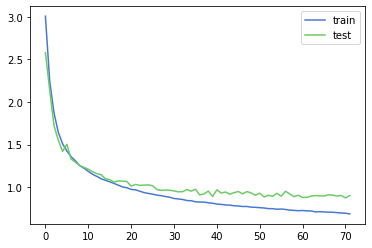

In [ ]:
plt.plot(history.history['loss'], label='train') 
plt.plot(history.history['val_loss'], label='test') 
plt.legend() 
plt.show()

###**Model 2, MFCCs**

In [ ]:
y = np.load(os.path.join(path2, 'all_labels_encoded.npy'))
mfccs = np.load(os.path.join(path2, 'all_mfccs.npy'))

In [ ]:
mfccs = np.expand_dims(mfccs, axis=3)

mfccs.shape

(93894, 26, 16, 1)

In [ ]:
x_train, x_test, Y_train, Y_test = train_test_split(np.array(mfccs), np.array(y), stratify=y, test_size = 0.2, random_state=32, shuffle=True)

####Model 2, 2D version of Model 1

In [ ]:
K.clear_session()

num_labels = len(labels)

model = Sequential()

model.add(Conv2D(filters=16, kernel_size=3, padding='valid', activation='relu', input_shape=(26, 16, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=(1, 1)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=(1, 1)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=(1, 1)))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(256, activation='relu'))

model.add(Dense(num_labels, activation='softmax'))


model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 24, 14, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 7, 16)         0         
_________________________________________________________________
dropout (Dropout)            (None, 12, 7, 16)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 5, 32)         4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 5, 32)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 5, 32)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 3, 64)          1

In [ ]:
batch_size = 128
num_epochs = 72

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, min_delta=0.0001) 
mc = ModelCheckpoint('best_model.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')

time_start = time.time()

history = model.fit(x_train, Y_train, batch_size=batch_size, epochs=num_epochs, verbose=1, callbacks=[mc], validation_data=(x_test, Y_test))

print('Run time: {} mins'.format((time.time()-time_start)/60))

Epoch 1/72
587/587 [==============================] - 3s 4ms/step - loss: 2.5880 - accuracy: 0.2624 - val_loss: 1.5933 - val_accuracy: 0.5322
Epoch 2/72
587/587 [==============================] - 2s 4ms/step - loss: 1.6625 - accuracy: 0.5039 - val_loss: 1.1981 - val_accuracy: 0.6477
Epoch 3/72
587/587 [==============================] - 2s 4ms/step - loss: 1.4054 - accuracy: 0.5770 - val_loss: 1.0406 - val_accuracy: 0.6889
Epoch 4/72
587/587 [==============================] - 2s 4ms/step - loss: 1.2665 - accuracy: 0.6167 - val_loss: 0.9609 - val_accuracy: 0.7166
Epoch 5/72
587/587 [==============================] - 2s 4ms/step - loss: 1.1891 - accuracy: 0.6390 - val_loss: 0.8832 - val_accuracy: 0.7330
Epoch 6/72
587/587 [==============================] - 2s 4ms/step - loss: 1.1280 - accuracy: 0.6558 - val_loss: 0.8523 - val_accuracy: 0.7441
Epoch 7/72
587/587 [==============================] - 2s 4ms/step - loss: 1.0822 - accuracy: 0.6704 - val_loss: 0.8158 - val_accuracy: 0.7553
Epoch 

####Model 2a

In [ ]:
K.clear_session()

num_labels = len(labels)

model = Sequential()

model.add(Conv2D(filters=16, kernel_size=3, padding='valid', activation='relu', input_shape=(26, 16, 1)))
model.add(MaxPooling2D(pool_size=(1, 1)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=(1, 1)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=(1, 1)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=(1, 1)))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(256, activation='relu'))

model.add(Dense(num_labels, activation='softmax'))


model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 24, 14, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 14, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 22, 12, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 22, 12, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 22, 12, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 10, 64)        1

In [ ]:
batch_size = 128
num_epochs = 72

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, min_delta=0.0001) 
mc = ModelCheckpoint('best_model.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')

time_start = time.time()

history = model.fit(x_train, Y_train, batch_size=batch_size, epochs=num_epochs, verbose=1, callbacks=[mc], validation_data=(x_test, Y_test))

print('Run time: {} mins'.format((time.time()-time_start)/60))

Epoch 1/72
587/587 [==============================] - 5s 8ms/step - loss: 1.7950 - accuracy: 0.4851 - val_loss: 0.9735 - val_accuracy: 0.7144
Epoch 2/72
587/587 [==============================] - 5s 8ms/step - loss: 0.9088 - accuracy: 0.7258 - val_loss: 0.7773 - val_accuracy: 0.7662
Epoch 3/72
587/587 [==============================] - 5s 8ms/step - loss: 0.6788 - accuracy: 0.7902 - val_loss: 0.7018 - val_accuracy: 0.7891
Epoch 4/72
587/587 [==============================] - 5s 8ms/step - loss: 0.5293 - accuracy: 0.8326 - val_loss: 0.7129 - val_accuracy: 0.7909
Epoch 5/72
587/587 [==============================] - 5s 8ms/step - loss: 0.4304 - accuracy: 0.8614 - val_loss: 0.7360 - val_accuracy: 0.7926
Epoch 6/72
587/587 [==============================] - 5s 8ms/step - loss: 0.3390 - accuracy: 0.8892 - val_loss: 0.7625 - val_accuracy: 0.7918
Epoch 7/72
587/587 [==============================] - 5s 8ms/step - loss: 0.2837 - accuracy: 0.9060 - val_loss: 0.8061 - val_accuracy: 0.7945
Epoch 

####Model 2b

In [ ]:
K.clear_session()

num_labels = len(labels)

model = Sequential()

model.add(Conv2D(filters=16, kernel_size=2, padding='valid', activation='relu', input_shape=(26, 16, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=32, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=(1, 1)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=(1, 1)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=(1, 1)))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(256, activation='relu'))

model.add(Dense(num_labels, activation='softmax'))


model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 25, 15, 16)        80        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 7, 16)         0         
_________________________________________________________________
dropout (Dropout)            (None, 12, 7, 16)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 6, 32)         2080      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 11, 6, 32)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 11, 6, 32)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 5, 64)         8

In [ ]:
batch_size = 128
num_epochs = 72

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, min_delta=0.0001) 
mc = ModelCheckpoint('best_model.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')

time_start = time.time()

history = model.fit(x_train, Y_train, batch_size=batch_size, epochs=num_epochs, verbose=1, callbacks=[mc], validation_data=(x_test, Y_test))

print('Run time: {} mins'.format((time.time()-time_start)/60))

Epoch 1/72
587/587 [==============================] - 3s 5ms/step - loss: 2.3796 - accuracy: 0.3274 - val_loss: 1.4037 - val_accuracy: 0.5929
Epoch 2/72
587/587 [==============================] - 3s 4ms/step - loss: 1.4572 - accuracy: 0.5661 - val_loss: 1.0901 - val_accuracy: 0.6813
Epoch 3/72
587/587 [==============================] - 3s 4ms/step - loss: 1.2178 - accuracy: 0.6329 - val_loss: 0.9409 - val_accuracy: 0.7219
Epoch 4/72
587/587 [==============================] - 3s 4ms/step - loss: 1.0776 - accuracy: 0.6741 - val_loss: 0.8665 - val_accuracy: 0.7391
Epoch 5/72
587/587 [==============================] - 3s 4ms/step - loss: 0.9795 - accuracy: 0.7026 - val_loss: 0.8252 - val_accuracy: 0.7526
Epoch 6/72
587/587 [==============================] - 3s 4ms/step - loss: 0.9064 - accuracy: 0.7222 - val_loss: 0.8006 - val_accuracy: 0.7568
Epoch 7/72
587/587 [==============================] - 3s 4ms/step - loss: 0.8476 - accuracy: 0.7400 - val_loss: 0.7771 - val_accuracy: 0.7646
Epoch 

###**Model 3, Audio**

This is based on the structure of a network built by Li et al (source 23).

In [ ]:
y = np.load(os.path.join(path2, 'all_labels_encoded.npy'))
audio = np.load(os.path.join(path2, 'all_audio.npy'))

audio = np.expand_dims(audio, axis=2)

print(audio.shape)

x_train, x_test, Y_train, Y_test = train_test_split(np.array(audio), np.array(y), stratify=y, test_size = 0.2, random_state=32, shuffle=True)

(93894, 8000, 1)


In [ ]:
K.clear_session()

num_labels = len(labels)

model = Sequential()

model.add(Conv1D(filters=128, kernel_size=3, padding='valid', activation='relu', input_shape=(8000, 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))

model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(Dropout(0.3))

model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(Dropout(0.3))

model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(Dropout(0.3))

model.add(Flatten())

model.add(Dense(num_labels, activation='softmax'))


model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 7998, 128)         512       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 3999, 128)         0         
_________________________________________________________________
dropout (Dropout)            (None, 3999, 128)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 3997, 128)         49280     
_________________________________________________________________
dropout_1 (Dropout)          (None, 3997, 128)         0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 3995, 128)         49280     
_________________________________________________________________
dropout_2 (Dropout)          (None, 3995, 128)         0

In [ ]:
batch_size = 128
num_epochs = 72

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, min_delta=0.0001) 
mc = ModelCheckpoint('best_model.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')

time_start = time.time()

history = model.fit(x_train, Y_train, batch_size=batch_size, epochs=num_epochs, verbose=1, callbacks=[mc], validation_data=(x_test, Y_test))

print('Run time: {} mins'.format((time.time()-time_start)/60))

Epoch 1/72
587/587 [==============================] - 103s 175ms/step - loss: 2.9048 - accuracy: 0.1894 - val_loss: 2.6744 - val_accuracy: 0.2478
Epoch 2/72
587/587 [==============================] - 102s 174ms/step - loss: 2.0820 - accuracy: 0.4198 - val_loss: 2.1148 - val_accuracy: 0.4210
Epoch 3/72
587/587 [==============================] - 102s 174ms/step - loss: 1.3712 - accuracy: 0.6135 - val_loss: 2.2324 - val_accuracy: 0.4246
Epoch 4/72
587/587 [==============================] - 102s 174ms/step - loss: 0.7487 - accuracy: 0.7823 - val_loss: 2.8405 - val_accuracy: 0.3955
Epoch 5/72
587/587 [==============================] - 102s 174ms/step - loss: 0.4162 - accuracy: 0.8767 - val_loss: 3.5784 - val_accuracy: 0.3885
Epoch 6/72
587/587 [==============================] - 102s 174ms/step - loss: 0.2650 - accuracy: 0.9194 - val_loss: 4.0007 - val_accuracy: 0.3681
Epoch 7/72
587/587 [==============================] - 102s 174ms/step - loss: 0.1973 - accuracy: 0.9405 - val_loss: 4.2269 -

###**Model 4, MFCCs**

This is a structure parallel to Model 3 but in 2D.

In [ ]:
y = np.load(os.path.join(path2, 'all_labels_encoded.npy'))
mfccs = np.load(os.path.join(path2, 'all_mfccs.npy'))

mfccs = np.expand_dims(mfccs, axis=3)

print(mfccs.shape)

x_train, x_test, Y_train, Y_test = train_test_split(np.array(mfccs), np.array(y), stratify=y, test_size = 0.2, random_state=32, shuffle=True)

(93894, 26, 16, 1)


####Model 4

In [ ]:
K.clear_session()

num_labels = len(labels)

model = Sequential()

model.add(Conv2D(filters=128, kernel_size=3, padding='valid', activation='relu', input_shape=(26, 16, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(filters=128, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=(1, 1)))
model.add(Dropout(0.3))

model.add(Conv2D(filters=128, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=(1, 1)))
model.add(Dropout(0.3))

model.add(Conv2D(filters=128, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=(1, 1)))
model.add(Dropout(0.3))

model.add(Flatten())

model.add(Dense(num_labels, activation='softmax'))


model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 24, 14, 128)       1280      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 7, 128)        0         
_________________________________________________________________
dropout (Dropout)            (None, 12, 7, 128)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 5, 128)        147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 5, 128)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 5, 128)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 3, 128)         1

In [ ]:
batch_size = 128
num_epochs = 72

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, min_delta=0.0001) 
mc = ModelCheckpoint('best_model.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')

time_start = time.time()

history = model.fit(x_train, Y_train, batch_size=batch_size, epochs=num_epochs, verbose=1, callbacks=[mc], validation_data=(x_test, Y_test))

print('Run time: {} mins'.format((time.time()-time_start)/60))

Epoch 1/72
587/587 [==============================] - 4s 7ms/step - loss: 2.4761 - accuracy: 0.2930 - val_loss: 1.3936 - val_accuracy: 0.5968
Epoch 2/72
587/587 [==============================] - 4s 6ms/step - loss: 1.4486 - accuracy: 0.5663 - val_loss: 1.0562 - val_accuracy: 0.6948
Epoch 3/72
587/587 [==============================] - 4s 6ms/step - loss: 1.2042 - accuracy: 0.6372 - val_loss: 0.8707 - val_accuracy: 0.7458
Epoch 4/72
587/587 [==============================] - 4s 6ms/step - loss: 1.0846 - accuracy: 0.6729 - val_loss: 0.7825 - val_accuracy: 0.7664
Epoch 5/72
587/587 [==============================] - 4s 6ms/step - loss: 1.0039 - accuracy: 0.6949 - val_loss: 0.7417 - val_accuracy: 0.7807
Epoch 6/72
587/587 [==============================] - 4s 6ms/step - loss: 0.9524 - accuracy: 0.7113 - val_loss: 0.7101 - val_accuracy: 0.7910
Epoch 7/72
587/587 [==============================] - 4s 6ms/step - loss: 0.9155 - accuracy: 0.7215 - val_loss: 0.6897 - val_accuracy: 0.7995
Epoch 

####Model 4a, tuning batch size, dropout rate, and pooling

In [ ]:
K.clear_session()

num_labels = len(labels)

model = Sequential()

model.add(Conv2D(filters=128, kernel_size=3, padding='valid', activation='relu', input_shape=(26, 16, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=3, activation='relu'))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=3, activation='relu'))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=3, activation='relu'))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(num_labels, activation='softmax'))


model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 24, 14, 128)       1280      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 7, 128)        0         
_________________________________________________________________
dropout (Dropout)            (None, 12, 7, 128)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 5, 128)        147584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 5, 128)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 3, 128)         147584    
_________________________________________________________________
dropout_2 (Dropout)          (None, 8, 3, 128)         0

In [ ]:
batch_size = 64
num_epochs = 72

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, min_delta=0.0001) 
mc = ModelCheckpoint('best_model.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')

time_start = time.time()

history = model.fit(x_train, Y_train, batch_size=batch_size, epochs=num_epochs, verbose=1, callbacks=[mc], validation_data=(x_test, Y_test))

print('Run time: {} mins'.format((time.time()-time_start)/60))

Epoch 1/72
1174/1174 [==============================] - 6s 5ms/step - loss: 2.1163 - accuracy: 0.3853 - val_loss: 1.1745 - val_accuracy: 0.6498
Epoch 2/72
1174/1174 [==============================] - 6s 5ms/step - loss: 1.1983 - accuracy: 0.6409 - val_loss: 0.8853 - val_accuracy: 0.7354
Epoch 3/72
1174/1174 [==============================] - 6s 5ms/step - loss: 1.0221 - accuracy: 0.6916 - val_loss: 0.8076 - val_accuracy: 0.7614
Epoch 4/72
1174/1174 [==============================] - 7s 6ms/step - loss: 0.9272 - accuracy: 0.7181 - val_loss: 0.7415 - val_accuracy: 0.7773
Epoch 5/72
1174/1174 [==============================] - 6s 5ms/step - loss: 0.8658 - accuracy: 0.7371 - val_loss: 0.7097 - val_accuracy: 0.7893
Epoch 6/72
1174/1174 [==============================] - 6s 5ms/step - loss: 0.8260 - accuracy: 0.7481 - val_loss: 0.6826 - val_accuracy: 0.7942
Epoch 7/72
1174/1174 [==============================] - 6s 5ms/step - loss: 0.7921 - accuracy: 0.7572 - val_loss: 0.6690 - val_accuracy:

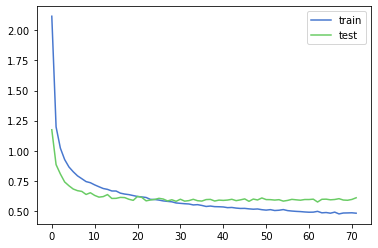

In [ ]:
plt.plot(history.history['loss'], label='train') 
plt.plot(history.history['val_loss'], label='test') 
plt.legend() 
plt.show()

####Model 4b, tuning batch size and pooling

In [ ]:
K.clear_session()

num_labels = len(labels)

model = Sequential()

model.add(Conv2D(filters=128, kernel_size=3, padding='valid', activation='relu', input_shape=(26, 16, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=(1, 1)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=3, activation='relu'))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=3, activation='relu'))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(num_labels, activation='softmax'))


model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 24, 14, 128)       1280      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 7, 128)        0         
_________________________________________________________________
dropout (Dropout)            (None, 12, 7, 128)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 5, 128)        147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 5, 128)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 5, 128)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 3, 128)         1

In [ ]:
batch_size = 32
num_epochs = 72

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, min_delta=0.0001) 
mc = ModelCheckpoint('best_model.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')

time_start = time.time()

history = model.fit(x_train, Y_train, batch_size=batch_size, epochs=num_epochs, verbose=1, callbacks=[mc], validation_data=(x_test, Y_test))

print('Run time: {} mins'.format((time.time()-time_start)/60))

Epoch 1/72
2348/2348 [==============================] - 9s 4ms/step - loss: 2.0476 - accuracy: 0.4025 - val_loss: 1.1901 - val_accuracy: 0.6519
Epoch 2/72
2348/2348 [==============================] - 9s 4ms/step - loss: 1.2141 - accuracy: 0.6361 - val_loss: 0.9037 - val_accuracy: 0.7354
Epoch 3/72
2348/2348 [==============================] - 9s 4ms/step - loss: 1.0602 - accuracy: 0.6792 - val_loss: 0.8630 - val_accuracy: 0.7418
Epoch 4/72
2348/2348 [==============================] - 9s 4ms/step - loss: 0.9945 - accuracy: 0.6976 - val_loss: 0.7810 - val_accuracy: 0.7664
Epoch 5/72
2348/2348 [==============================] - 9s 4ms/step - loss: 0.9384 - accuracy: 0.7147 - val_loss: 0.7487 - val_accuracy: 0.7806
Epoch 6/72
2348/2348 [==============================] - 9s 4ms/step - loss: 0.9149 - accuracy: 0.7221 - val_loss: 0.7508 - val_accuracy: 0.7768
Epoch 7/72
2348/2348 [==============================] - 9s 4ms/step - loss: 0.8872 - accuracy: 0.7299 - val_loss: 0.7059 - val_accuracy:

####Model 4c, tuning batch size, pooling, and number of filters

In [ ]:
K.clear_session()

num_labels = len(labels)

model = Sequential()

model.add(Conv2D(filters=128, kernel_size=3, padding='valid', activation='relu', input_shape=(26, 16, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=3, activation='relu'))
model.add(Dropout(0.2))

model.add(Conv2D(filters=256, kernel_size=3, activation='relu'))
model.add(Dropout(0.2))

model.add(Conv2D(filters=512, kernel_size=3, activation='relu'))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(num_labels, activation='softmax'))


model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 24, 14, 128)       1280      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 7, 128)        0         
_________________________________________________________________
dropout (Dropout)            (None, 12, 7, 128)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 5, 128)        147584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 5, 128)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 3, 256)         295168    
_________________________________________________________________
dropout_2 (Dropout)          (None, 8, 3, 256)         0

In [ ]:
batch_size = 64
num_epochs = 72

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, min_delta=0.0001) 
mc = ModelCheckpoint('best_model.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')

time_start = time.time()

history = model.fit(x_train, Y_train, batch_size=batch_size, epochs=num_epochs, verbose=1, callbacks=[mc], validation_data=(x_test, Y_test))

print('Run time: {} mins'.format((time.time()-time_start)/60))

Epoch 1/72
1174/1174 [==============================] - 7s 6ms/step - loss: 1.9040 - accuracy: 0.4460 - val_loss: 1.0356 - val_accuracy: 0.6886
Epoch 2/72
1174/1174 [==============================] - 7s 6ms/step - loss: 1.0710 - accuracy: 0.6770 - val_loss: 0.8069 - val_accuracy: 0.7549
Epoch 3/72
1174/1174 [==============================] - 7s 6ms/step - loss: 0.8859 - accuracy: 0.7295 - val_loss: 0.7168 - val_accuracy: 0.7801
Epoch 4/72
1174/1174 [==============================] - 7s 6ms/step - loss: 0.8049 - accuracy: 0.7535 - val_loss: 0.6720 - val_accuracy: 0.7946
Epoch 5/72
1174/1174 [==============================] - 7s 6ms/step - loss: 0.7326 - accuracy: 0.7744 - val_loss: 0.6655 - val_accuracy: 0.7988
Epoch 6/72
1174/1174 [==============================] - 7s 6ms/step - loss: 0.6860 - accuracy: 0.7873 - val_loss: 0.6611 - val_accuracy: 0.7998
Epoch 7/72
1174/1174 [==============================] - 7s 6ms/step - loss: 0.6497 - accuracy: 0.7982 - val_loss: 0.6518 - val_accuracy:

###**Model 5, MFCCs**

**From here on out, I'll be using MFCCs only, as they get accuracy better than or comparable to running the full audio set through the model and do so with less computational resources.**

**This model is based on that found in [source 22](https://docs.google.com/document/d/1KtxPHVX04ckFckqGBh2zfX-OHk5cBf-ZpomcGE-9u_g/edit?usp=sharing); those researchers found an accuracy of 81.8% and used 10 convolutional layers.  Because my feature space is smaller than theirs ((?, 26, 16) vs (?, 40, 123)), I'm only using 4 convolutional layers followed by 3 dense layers. I'm not using Maxout for any of the layers for the same reason.**

In [ ]:
K.clear_session()

num_labels = len(labels)

channels_axis=3  #is this the correct channel_axis?

model = Sequential()

model.add(Conv2D(filters=128, kernel_size=3, padding='valid', activation='relu', input_shape=(26, 16, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(filters=128, kernel_size=3, activation='relu'))
model.add(Lambda(lambda x: K.max(x, axis=channels_axis, keepdims=True)))
model.add(Dropout(0.3))

model.add(Conv2D(filters=256, kernel_size=3, activation='relu'))
model.add(Lambda(lambda x: K.max(x, axis=channels_axis, keepdims=True)))
model.add(Dropout(0.3))

model.add(Conv2D(filters=256, kernel_size=3, activation='relu'))
model.add(Lambda(lambda x: K.max(x, axis=channels_axis, keepdims=True)))
model.add(Dropout(0.3))

model.add(Flatten())

model.add(Dense(512, activation='relu'))

model.add(Dense(512, activation='relu'))

model.add(Dense(512, activation='relu'))

model.add(Dense(num_labels, activation='softmax'))


model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 24, 14, 128)       1280      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 7, 128)        0         
_________________________________________________________________
dropout (Dropout)            (None, 12, 7, 128)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 5, 128)        147584    
_________________________________________________________________
lambda (Lambda)              (None, 10, 5, 1)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 5, 1)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 3, 256)         2

In [ ]:
batch_size = 20
num_epochs = 72

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, min_delta=0.0001) 
mc = ModelCheckpoint('best_model.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')

time_start = time.time()

history = model.fit(x_train, Y_train, batch_size=batch_size, epochs=num_epochs, verbose=1, callbacks=[mc], validation_data=(x_test, Y_test))

print('Run time: {} mins'.format((time.time()-time_start)/60))

Epoch 1/72
3756/3756 [==============================] - 19s 5ms/step - loss: 3.4701 - accuracy: 0.0380 - val_loss: 3.4669 - val_accuracy: 0.0400
Epoch 2/72
3756/3756 [==============================] - 18s 5ms/step - loss: 3.4674 - accuracy: 0.0381 - val_loss: 3.4671 - val_accuracy: 0.0397
Epoch 3/72
3756/3756 [==============================] - 18s 5ms/step - loss: 3.4673 - accuracy: 0.0388 - val_loss: 3.4663 - val_accuracy: 0.0379
Epoch 4/72
3756/3756 [==============================] - 18s 5ms/step - loss: 3.4669 - accuracy: 0.0381 - val_loss: 3.4661 - val_accuracy: 0.0380
Epoch 5/72
3756/3756 [==============================] - 18s 5ms/step - loss: 3.4667 - accuracy: 0.0385 - val_loss: 3.4666 - val_accuracy: 0.0393
Epoch 6/72
3756/3756 [==============================] - 18s 5ms/step - loss: 3.4666 - accuracy: 0.0384 - val_loss: 3.4661 - val_accuracy: 0.0397
Epoch 7/72
3756/3756 [==============================] - 18s 5ms/step - loss: 3.4665 - accuracy: 0.0385 - val_loss: 3.4669 - val_ac

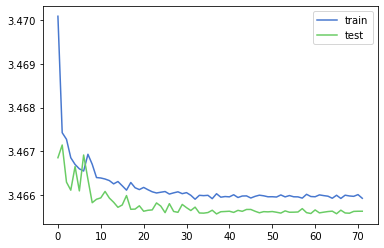

In [ ]:
plt.plot(history.history['loss'], label='train') 
plt.plot(history.history['val_loss'], label='test') 
plt.legend() 
plt.show()

###**Model 6, Audio**

**Model 5 had very poor results, so I'll try running the same model on the Audio rather than the MFCCs.  Model 3 and Model 4 are structured the same, but they worked very well on MFCCs and poorly on Audio, so I'll see if the inverse is true here.  I will increase the batch_size, though, because of the larger size of the Audio dataset.**

In [ ]:
y = np.load(os.path.join(path2, 'all_labels_encoded.npy'))
audio = np.load(os.path.join(path2, 'all_audio.npy'))

audio = np.expand_dims(audio, axis=2)

print(audio.shape)

x_train, x_test, Y_train, Y_test = train_test_split(np.array(audio), np.array(y), stratify=y, test_size = 0.2, random_state=32, shuffle=True)

(93894, 8000, 1)


In [ ]:
K.clear_session()

num_labels = len(labels)

channels_axis=2

model = Sequential()

model.add(Conv1D(filters=128, kernel_size=3, padding='valid', activation='relu', input_shape=(8000, 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))

model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(Lambda(lambda x: K.max(x, axis=channels_axis, keepdims=True)))
model.add(Dropout(0.3))

model.add(Conv1D(filters=256, kernel_size=3, activation='relu'))
model.add(Lambda(lambda x: K.max(x, axis=channels_axis, keepdims=True)))
model.add(Dropout(0.3))

model.add(Conv1D(filters=256, kernel_size=3, activation='relu'))
model.add(Lambda(lambda x: K.max(x, axis=channels_axis, keepdims=True)))
model.add(Dropout(0.3))

model.add(Flatten())

model.add(Dense(512, activation='relu'))

model.add(Dense(512, activation='relu'))

model.add(Dense(512, activation='relu'))

model.add(Dense(num_labels, activation='softmax'))


model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 7998, 128)         512       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 3999, 128)         0         
_________________________________________________________________
dropout (Dropout)            (None, 3999, 128)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 3997, 128)         49280     
_________________________________________________________________
lambda (Lambda)              (None, 3997, 1)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 3997, 1)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 3995, 256)         1

In [ ]:
batch_size = 64
num_epochs = 72

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, min_delta=0.0001) 
mc = ModelCheckpoint('best_model.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')

time_start = time.time()

history = model.fit(x_train, Y_train, batch_size=batch_size, epochs=num_epochs, verbose=1, callbacks=[mc], validation_data=(x_test, Y_test))

print('Run time: {} mins'.format((time.time()-time_start)/60))

Epoch 1/72
1174/1174 [==============================] - 94s 80ms/step - loss: 3.4703 - accuracy: 0.0374 - val_loss: 3.4667 - val_accuracy: 0.0393
Epoch 2/72
1174/1174 [==============================] - 94s 80ms/step - loss: 3.4674 - accuracy: 0.0380 - val_loss: 3.4663 - val_accuracy: 0.0393
Epoch 3/72
1174/1174 [==============================] - 93s 80ms/step - loss: 3.4673 - accuracy: 0.0392 - val_loss: 3.4671 - val_accuracy: 0.0380
Epoch 4/72
1174/1174 [==============================] - 94s 80ms/step - loss: 3.4669 - accuracy: 0.0388 - val_loss: 3.4664 - val_accuracy: 0.0393
Epoch 5/72
1174/1174 [==============================] - 93s 80ms/step - loss: 3.4668 - accuracy: 0.0387 - val_loss: 3.4661 - val_accuracy: 0.0375
Epoch 6/72
 155/1174 [==>...........................] - ETA: 1:15 - loss: 3.4665 - accuracy: 0.0414

KeyboardInterrupt: ignored

This one is so bad and slow I'm stopping it early.

###**Model 7, MFCCs**

**This is my last attempt to polish and tune the best MFCC model.**

In [ ]:
y = np.load(os.path.join(path2, 'all_labels_encoded.npy'))
mfccs = np.load(os.path.join(path2, 'all_mfccs.npy'))

mfccs = np.expand_dims(mfccs, axis=3)

print(mfccs.shape)

x_train, x_test, Y_train, Y_test = train_test_split(np.array(mfccs), np.array(y), stratify=y, test_size = 0.2, random_state=32, shuffle=True)

(93894, 26, 16, 1)


In [ ]:
K.clear_session()

num_labels = len(labels)

model = Sequential()

model.add(Conv2D(filters=128, kernel_size=3, padding='valid', activation='relu', input_shape=(26, 16, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=3, activation='relu'))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=3, activation='relu'))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=3, activation='relu'))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(128, activation='relu'))

model.add(Dense(num_labels, activation='softmax'))


model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 24, 14, 128)       1280      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 7, 128)        0         
_________________________________________________________________
dropout (Dropout)            (None, 12, 7, 128)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 5, 128)        147584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 5, 128)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 3, 128)         147584    
_________________________________________________________________
dropout_2 (Dropout)          (None, 8, 3, 128)         0

In [ ]:
batch_size = 64
num_epochs = 72

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, min_delta=0.0001) 
mc = ModelCheckpoint('best_model.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')

time_start = time.time()

history = model.fit(x_train, Y_train, batch_size=batch_size, epochs=num_epochs, verbose=1, callbacks=[mc], validation_data=(x_test, Y_test))

print('Run time: {} mins'.format((time.time()-time_start)/60))

Epoch 1/72
1174/1174 [==============================] - 6s 5ms/step - loss: 2.1786 - accuracy: 0.3681 - val_loss: 1.1642 - val_accuracy: 0.6584
Epoch 2/72
1174/1174 [==============================] - 6s 5ms/step - loss: 1.1925 - accuracy: 0.6373 - val_loss: 0.8884 - val_accuracy: 0.7330
Epoch 3/72
1174/1174 [==============================] - 6s 5ms/step - loss: 1.0081 - accuracy: 0.6904 - val_loss: 0.8179 - val_accuracy: 0.7557
Epoch 4/72
1174/1174 [==============================] - 6s 5ms/step - loss: 0.9145 - accuracy: 0.7218 - val_loss: 0.7523 - val_accuracy: 0.7731
Epoch 5/72
1174/1174 [==============================] - 6s 5ms/step - loss: 0.8568 - accuracy: 0.7372 - val_loss: 0.7012 - val_accuracy: 0.7872
Epoch 6/72
1174/1174 [==============================] - 6s 5ms/step - loss: 0.8141 - accuracy: 0.7494 - val_loss: 0.6818 - val_accuracy: 0.7964
Epoch 7/72
1174/1174 [==============================] - 6s 5ms/step - loss: 0.7798 - accuracy: 0.7600 - val_loss: 0.6695 - val_accuracy:

####Model 7a, tuning kernel_size

In [ ]:
K.clear_session()

num_labels = len(labels)

model = Sequential()

model.add(Conv2D(filters=128, kernel_size=2, padding='valid', activation='relu', input_shape=(26, 16, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=2, activation='relu'))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=2, activation='relu'))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=2, activation='relu'))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(128, activation='relu'))

model.add(Dense(num_labels, activation='softmax'))


model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 25, 15, 128)       640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 7, 128)        0         
_________________________________________________________________
dropout (Dropout)            (None, 12, 7, 128)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 6, 128)        65664     
_________________________________________________________________
dropout_1 (Dropout)          (None, 11, 6, 128)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 5, 128)        65664     
_________________________________________________________________
dropout_2 (Dropout)          (None, 10, 5, 128)        0

In [ ]:
batch_size = 64
num_epochs = 72

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, min_delta=0.0001) 
mc = ModelCheckpoint('best_model.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')

time_start = time.time()

history = model.fit(x_train, Y_train, batch_size=batch_size, epochs=num_epochs, verbose=1, callbacks=[mc], validation_data=(x_test, Y_test))

print('Run time: {} mins'.format((time.time()-time_start)/60))

Epoch 1/72
1174/1174 [==============================] - 7s 6ms/step - loss: 1.8808 - accuracy: 0.4533 - val_loss: 0.9950 - val_accuracy: 0.7070
Epoch 2/72
1174/1174 [==============================] - 6s 5ms/step - loss: 1.0060 - accuracy: 0.6985 - val_loss: 0.8313 - val_accuracy: 0.7480
Epoch 3/72
1174/1174 [==============================] - 6s 5ms/step - loss: 0.8352 - accuracy: 0.7465 - val_loss: 0.7391 - val_accuracy: 0.7782
Epoch 4/72
1174/1174 [==============================] - 6s 5ms/step - loss: 0.7449 - accuracy: 0.7724 - val_loss: 0.6711 - val_accuracy: 0.7979
Epoch 5/72
1174/1174 [==============================] - 7s 6ms/step - loss: 0.6780 - accuracy: 0.7896 - val_loss: 0.6758 - val_accuracy: 0.7963
Epoch 6/72
1174/1174 [==============================] - 7s 6ms/step - loss: 0.6290 - accuracy: 0.8038 - val_loss: 0.6427 - val_accuracy: 0.8097
Epoch 7/72
1174/1174 [==============================] - 6s 5ms/step - loss: 0.5851 - accuracy: 0.8162 - val_loss: 0.6398 - val_accuracy:

#***Summary and Conclusions***

A full list of the models, their parameters, their accuracy rates, and their runtimes can be found [in this spreadsheet](https://docs.google.com/spreadsheets/d/14gmZQ5KOuHXWG56O5N_PXGECjSVSUjJr0C5NGMiOcT8/edit?usp=sharing).

The best model, highlighted in yellow on the spreadsheet, is **4a**.  It consists of four Conv2D layers of kernel_size = 3 with one (2,2) sized MaxPooling layer after the first Conv2D layer and Dropout after each layer at a rate of 0.2.  It uses a batch size of 64 and trained over 72 epochs.  This model has a **training accuracy of 84%** and a **test accuracy of 83.26%** and avoids overfitting. Its runtime is a little over 6 minutes.  This model runs only on MFCCs without needing the original audio data, saving computational resources.  The model is more accurate than the more computationally demanding model described by Zhang et al in their 2017 paper [(source 22)](https://docs.google.com/document/d/1KtxPHVX04ckFckqGBh2zfX-OHk5cBf-ZpomcGE-9u_g/edit?usp=sharing).

As you can see in the confusion matrix below, the most-confused pairs of words are:


*   three / tree
*   go / no
*  forward / four
* off / up



This model could be further refined by ensembling or by combining RNNs with CNNs, as some successful sound recognition models do.  Extracting audio features beyond MFCCs, including zero-crossing rate, short-time energy, and spectral flux could be explored as possible ways to improve the model, though spectral features may be less useful for speech recognition than for music information retrieval (MIR) because of the relatively monotonic nature of speech.  Some studies de-noise their samples, while others add in extra background noise to ensure the model is training on all possible types of real-life sound recordings; one or both of these could be attempted and results could be compared with the existing model.

###**Success Metrics + Confusion Matrix, Model 4a**

####Success Metrics

In [ ]:
predictions = np.round(model.predict(x_test), 0)
print('rounded test labels', predictions)

In [ ]:
classification_metrics = classification_report(Y_test, predictions, target_names=labels)
print(classification_metrics)

              precision    recall  f1-score   support

         bed       0.89      0.68      0.77       337
        bird       0.93      0.73      0.82       352
         cat       0.84      0.80      0.82       343
         dog       0.88      0.74      0.80       364
        down       0.86      0.80      0.83       716
       eight       0.93      0.88      0.90       688
        five       0.90      0.80      0.85       745
      follow       0.88      0.66      0.76       291
     forward       0.82      0.53      0.65       292
        four       0.79      0.85      0.82       681
          go       0.82      0.70      0.75       698
       happy       0.94      0.87      0.90       353
       house       0.89      0.85      0.87       366
       learn       0.79      0.68      0.73       285
        left       0.90      0.83      0.86       700
      marvin       0.92      0.89      0.90       366
        nine       0.90      0.86      0.88       726
          no       0.80    

####Defining the Confusion Matrix

In [ ]:
Y_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
Y_test_df = pd.DataFrame(Y_test, columns=labels)

Y_test_labels = pd.get_dummies(Y_test_df).idxmax(1)

In [ ]:
predictions_df = pd.DataFrame(predictions, columns=labels)

predictions_labels = pd.get_dummies(predictions_df).idxmax(1)

In [ ]:
confusion = confusion_matrix(Y_test_labels, predictions_labels)
confusion

array([[282,   0,   4, ...,   0,   2,   1],
       [ 42, 256,   1, ...,   0,   1,   2],
       [ 31,   0, 275, ...,   0,   9,   0],
       ...,
       [ 32,   0,   1, ..., 297,   1,   0],
       [ 36,   0,   7, ...,   1, 656,   1],
       [ 42,   0,   0, ...,   0,   2, 639]])

In [ ]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap="YlGnBu",
                          normalize=True):

    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(25, 25))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

####Confusion Matrix

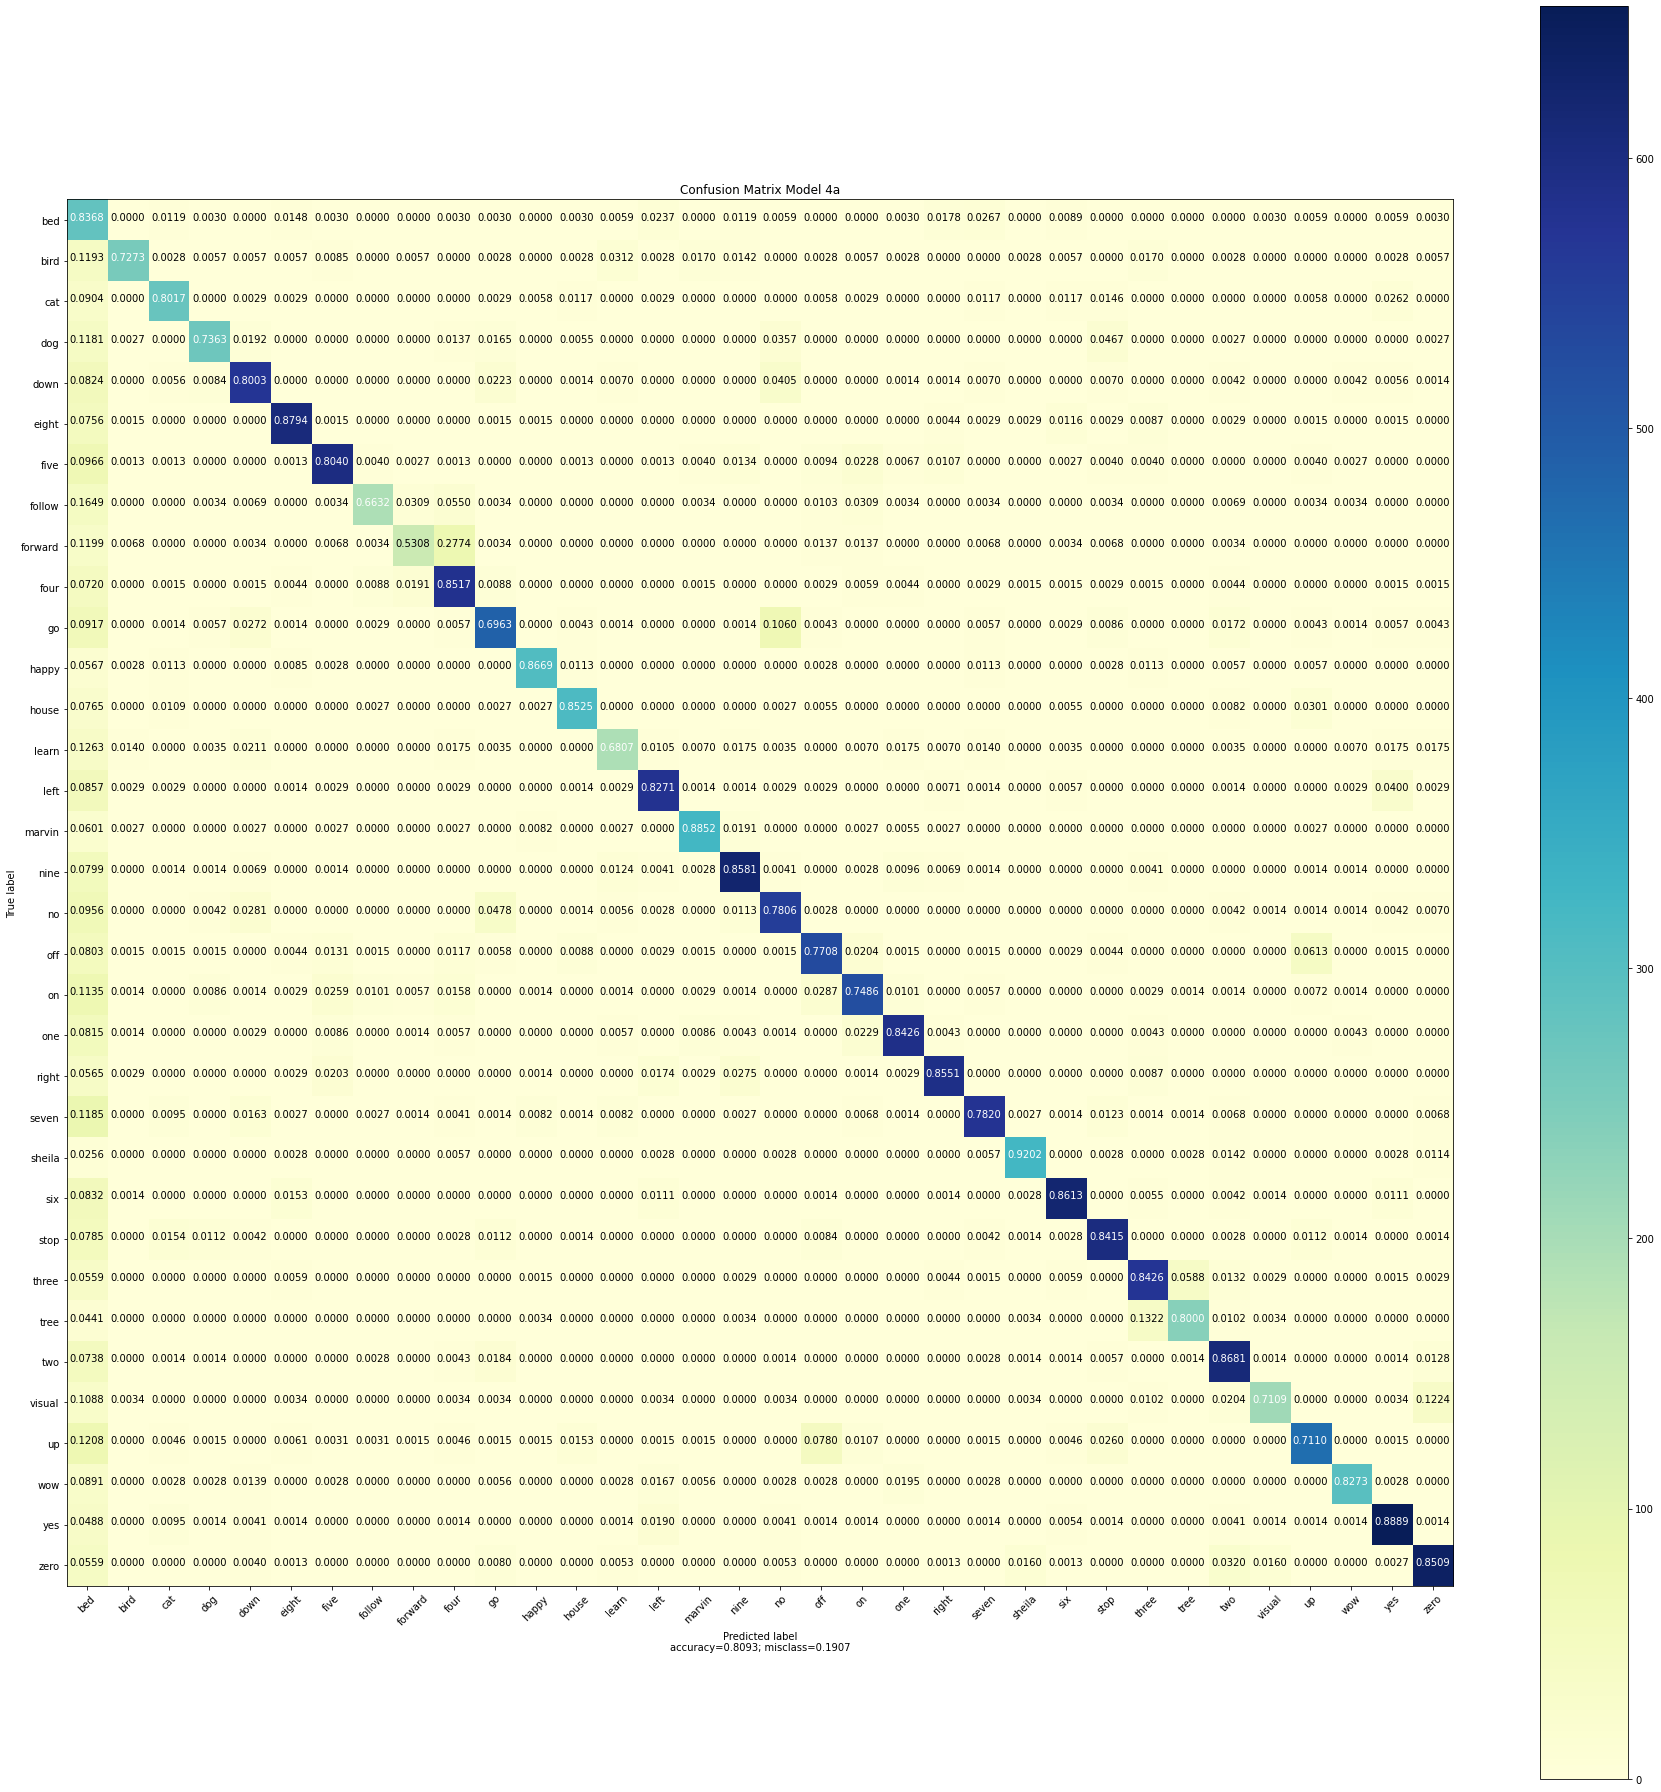

In [ ]:
plot_confusion_matrix(cm=confusion, target_names = labels, title = 'Confusion Matrix Model 4a', normalize=True)